***
## Generator

**Simulative training of the Generator** for the scholar model.

The generator implemented in *GenerativeModel.py* is hereafter wrapped into a trainable strategy, to be passed to the generator_strategy parameter when using Deep Generative Replay learning strategy.

**Any kind** of generative model can be used, hereafter is made use of a *VAE generator*.
***

In [1]:
# Import the VAE generative model
from imports.GenerativeModel import VAE_model

# Import the VAE training class
from imports.TrainingInstances import VAE_TrainingStrategy

In [2]:
# --- LIBRARIES AND UTILS ---
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import unittest

import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop
import torch.optim.lr_scheduler
import matplotlib.pyplot as plt
import numpy as np

# Avalanche library from ContinualAI
import avalanche

from avalanche.benchmarks.datasets import MNIST
from avalanche.benchmarks.generators import nc_benchmark

# Loggers
from avalanche.logging import InteractiveLogger, TensorboardLogger

# Evaluation
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics, timing_metrics, forgetting_metrics

# Extras: Model and utils
from utils import arguments

In [3]:
class Generator(unittest.TestCase):

    # Split-MNIST benchmark
    def test_smnist(self, override_args=None):

        # --- CONFIG
        device = torch.device(f"cuda:{args.cuda}"
            if torch.cuda.is_available() and args.cuda >= 0
            else "cpu")
        

        # --- BENCHMARK and SCENARIO
        train_transform = Compose([RandomCrop(28, padding=4), ToTensor(), Normalize((0.1307,), (0.3081,)) ])
        test_transform  = Compose([ToTensor(), Normalize((0.1307,), (0.3081,)) ])

        mnist_train = MNIST('./data/mnist', train=True, download=True, transform=train_transform)
        mnist_test  = MNIST('./data/mnist', train=False, download=True, transform=test_transform)
        
        scenario = nc_benchmark(train_dataset= mnist_train,
                                test_dataset = mnist_test,
                                n_experiences= 5,
                                seed= 1234,
                                task_labels  = False)
        # ---------
        
        # --- Strategy instantiation --- # 
        # 1. Model of the generator
        # 2. Optimizer of the generator
        
        # ADDITIONAL ARGUMENTS allow to customize training
        args = arguments({ 'cuda': 0,              # GPU or CPU
                           'train_epochs': 1,      # Training epochs
                           'train_mb_size': 100,   # Train minibatch size
                         }, override_args) 
        
        # Generator model
        model = VAE_model((1, 28, 28), nhid=2, device=device)
        
        # Optimizer of the generator
        optimizer = Adam(model.parameters(), lr=0.001)
        
        # Wrap the generative model into a trainable strategy
        cl_strategy = VAE_TrainingStrategy(
            model, optimizer, # criterion is adapted in TrainingStrategies.py to VAE loss
            train_mb_size=args.train_mb_size,
            train_epochs =args.train_epochs,
            device=device)

        # TRAINING LOOP
        print("Starting experiment...")
        f, axarr = plt.subplots(scenario.n_experiences, 10)
        k = 0
        for experience in scenario.train_stream:
            print('Current experience {}, contains: {} patterns'.format(experience.current_experience, len(experience.dataset)))
            print('Current classes: ',experience.classes_in_this_experience)

            # Train
            cl_strategy.train(experience)
            print('Training completed')

            samples = model.generate(10)
            samples = samples.detach().cpu().numpy()

            for j in range(10):
                axarr[k, j].imshow(samples[j, 0], cmap="gray")
                axarr[k, 4].set_title("Generated images for task " + str(k))
            np.vectorize(lambda ax: ax.axis("off"))(axarr)
            k += 1

        #f.tight_layout()
        plt.savefig("VAE_GeneratedImages")
        plt.show()

### Run the experiment
- Create an instance of the strategy object
- Execute the strategy on a benchmark

Starting experiment...
Current experience 0, contains: 11263 patterns
Current classes:  [4, 5]
-- >> Start of training phase << --
100%|██████████| 113/113 [00:05<00:00, 21.08it/s]
Epoch 0 ended.
-- >> End of training phase << --
Training completed
Current experience 1, contains: 11809 patterns
Current classes:  [8, 2]
-- >> Start of training phase << --
100%|██████████| 119/119 [00:05<00:00, 20.68it/s]
Epoch 0 ended.
-- >> End of training phase << --
Training completed
Current experience 2, contains: 11867 patterns
Current classes:  [9, 6]
-- >> Start of training phase << --
100%|██████████| 119/119 [00:05<00:00, 21.12it/s]
Epoch 0 ended.
-- >> End of training phase << --
Training completed
Current experience 3, contains: 13007 patterns
Current classes:  [1, 7]
-- >> Start of training phase << --
100%|██████████| 131/131 [00:06<00:00, 20.77it/s]
Epoch 0 ended.
-- >> End of training phase << --
Training completed
Current experience 4, contains: 12054 patterns
Current classes:  [0, 3]
-

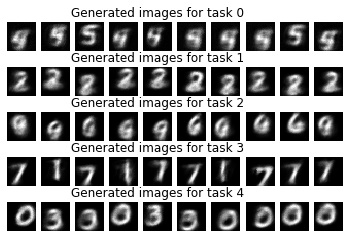

In [4]:
# Create the strategy
s = Generator()

# Run the experiment with custom parameters
s.test_smnist()
